In [97]:
%config IPCompleter.greedy=True

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [101]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

### Dataset

In [103]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [105]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [107]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

610
9724


# Spotlight

### Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used if needed.

In [109]:
from collections import defaultdict
from itertools import count

uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 2518


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

### Implicit Factorization model

In [111]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))

In [113]:
print(implicit_train)
print(implicit_test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [115]:
converted_train_users = []
converted_train_movies = []
rating_train = []
for i in range(len(implicit_train.user_ids)):
    converted_train_users.append(uid_rev_map[implicit_train.user_ids[i]])
    converted_train_movies.append(iid_rev_map[implicit_train.item_ids[i]])
    rating_train.append(float(ratings_df['rating'][(ratings_df['movieId']==converted_train_movies[i]) & (ratings_df['userId']==converted_train_users[i])].values))

#train_df = pd.DataFrame({'user_id':implicit_train.user_ids,'movie_id':implicit_train.item_ids,'timestamp':implicit_train.timestamps})
train_df = pd.DataFrame({'user_id':converted_train_users,'movie_id':converted_train_movies,'rating':rating_train})
#train_df

In [117]:
float(ratings_df['rating'][(ratings_df['movieId']==5378) & (ratings_df['userId']==190)].values)

3.0

In [119]:
converted_test_users = []
converted_test_movies = []
rating_test = []
for i in range(len(implicit_test.user_ids)):
    converted_test_users.append(uid_rev_map[implicit_test.user_ids[i]])
    converted_test_movies.append(iid_rev_map[implicit_test.item_ids[i]])
    rating_test.append(float(ratings_df['rating'][(ratings_df['movieId']==converted_test_movies[i]) & (ratings_df['userId']==converted_test_users[i])].values))

test_df = pd.DataFrame({'user_id':converted_test_users,'movie_id':converted_test_movies,'rating':rating_test})

test_df

,user_id,movie_id,rating
0,514,3244,2.5
1,356,53956,3.5
2,601,74458,4.5
3,132,1721,3.0
4,4,1073,4.0
...,...,...,...
20163,605,837,3.0
20164,74,2858,5.0
20165,76,51662,3.0
20166,552,4638,1.0


### Implicit Factorization model implementation

In [121]:
implicit_model  = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

implicit_model.fit(implicit_train,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.7056821062217785
Epoch 1: loss 0.431904540597638
Epoch 2: loss 0.3893871847775918
Epoch 3: loss 0.35498065322260314
Epoch 4: loss 0.3275492428507231
Training took 86 second


MRR score of the Implicit recommender

In [123]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.3031284601168061


Distribution of scores for a user

(array([6.000e+00, 2.100e+01, 5.200e+01, 1.360e+02, 3.370e+02, 8.280e+02,
        1.393e+03, 1.481e+03, 1.132e+03, 6.280e+02, 4.460e+02, 2.810e+02,
        2.310e+02, 2.010e+02, 1.820e+02, 1.940e+02, 1.490e+02, 1.490e+02,
        1.390e+02, 1.240e+02, 1.150e+02, 1.320e+02, 1.260e+02, 1.140e+02,
        1.030e+02, 9.000e+01, 1.240e+02, 9.500e+01, 8.600e+01, 9.300e+01,
        1.470e+02, 1.090e+02, 1.090e+02, 1.000e+02, 4.300e+01, 2.100e+01,
        5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-15.408419  , -14.619114  , -13.829808  , -13.0405035 ,
        -12.251199  , -11.461893  , -10.672588  ,  -9.883284  ,
         -9.093978  ,  -8.304673  ,  -7.515368  ,  -6.726063  ,
         -5.936758  ,  -5.147453  ,  -4.3581476 ,  -3.5688426 ,
         -2.7795377 ,  -1.9902325 ,  -1.2009275 ,  -0.41162238,
          0.3776827 ,   1.1669878 ,   1.9562929 ,   2.7455978 ,
          3.534903  ,   4.3242083 ,   5.113513  ,   5.902818  ,
          6.6921234 ,   7.481428  ,   8.270733  ,   9.

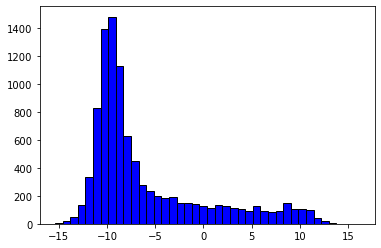

In [125]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

In [127]:
import scipy.stats as st

def moviesForUser(user, k=100):
  a= list()
  ranks = st.rankdata(-implicit_model.predict(user))  
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = moviesForUser(0)
print(rec_forUser)

[3, 6, 47, 50, 110, 260, 296, 316, 349, 356, 367, 457, 480, 527, 590, 592, 593, 608, 648, 733, 736, 780, 1032, 1097, 1196, 1197, 1198, 1210, 1214, 1240, 1270, 1291, 1396, 1573, 1617, 1676, 1732, 2054, 2193, 2470, 2617, 2700, 2716, 2797, 2916, 2985, 3578, 318, 1371, 21, 32, 368, 539, 1183, 1259, 1968, 2762, 39, 153, 253, 300, 344, 364, 380, 474, 589, 594, 597, 10, 19, 329, 339, 377, 432, 454, 494, 520, 587, 924, 1584, 172, 858, 1200, 1036, 1221, 2194, 173, 1372, 1380, 1645, 2302, 2455, 2915, 3418, 1035, 29, 3256, 1242, 786, 1320]


In [129]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
18,19,Ace Ventura: When Nature Calls (1995),Comedy
20,21,Get Shorty (1995),Comedy|Crime|Thriller
...,...,...,...
2193,2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller
2248,2985,RoboCop (1987),Action|Crime|Drama|Sci-Fi|Thriller
2443,3256,Patriot Games (1992),Action|Crime|Drama|Thriller
2553,3418,Thelma & Louise (1991),Adventure|Crime|Drama


In [131]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Actual movies watched

In [133]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [135]:
actual = actual.index.tolist()

In [137]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
62,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
...,...,...,...
1332,1804,"Newton Boys, The (1998)",Crime|Drama
1333,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
1401,1920,Small Soldiers (1998),Animation|Children|Fantasy|War
2991,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [139]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score for each user

### Note: The implementation below is the NDCG score for the first user only! I will include them all with a loop, but to avoid the loss of time I will do it after the solution is finalized and thought as correct!

In [141]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [143]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [145]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [147]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [149]:
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.6646314850111873


# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [151]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [153]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)


To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [157]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [159]:
svd_predictions_score_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.861726,0.937778,0.975957,-0.017830,0.216177,1.702736,0.105428,0.000205,0.146076,1.997412,...,-0.012587,-0.010789,-0.014386,-0.014386,-0.012587,-0.014386,-0.012587,-0.012587,-0.012587,-0.019309
1,0.192522,-0.008264,-0.026998,0.003019,0.025943,0.086721,-0.056641,0.012829,-0.012171,-0.078800,...,0.005953,0.005103,0.006803,0.006803,0.005953,0.006803,0.005953,0.005953,0.005953,0.013188
2,0.031622,0.016571,0.019504,-0.004169,-0.015130,0.078697,-0.013183,0.000482,0.007625,0.063260,...,0.000239,0.000205,0.000273,0.000273,0.000239,0.000273,0.000239,0.000239,0.000239,-0.001889
3,1.574333,0.233673,0.278655,0.056570,0.187347,0.267250,0.328903,-0.054729,-0.018870,0.078537,...,-0.001781,-0.001527,-0.002036,-0.002036,-0.001781,-0.002036,-0.001781,-0.001781,-0.001781,-0.010068
4,1.277728,0.976974,0.422940,0.126277,0.537362,0.751711,0.630211,0.116558,0.117054,1.154697,...,0.000582,0.000499,0.000665,0.000665,0.000582,0.000665,0.000582,0.000582,0.000582,-0.000066


In [ ]:
svd_predictions_score_df[svd_predictions_score_df.index == 2]

In [ ]:
len(svd_predictions_score[0])

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [ ]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
already_rated.head()

In [ ]:
predictions

In [ ]:
predicted_rank_svd = predictions['movieId'].index.tolist()

In [ ]:
relevance_SVD = []
for i in range(len(predicted_rank_svd)):
    if predicted_rank_svd[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_SVD.append(1)
    else:
        relevance_SVD.append(0)

In [ ]:
ndcg = NDCG_forUser(relevance_SVD)
print(ndcg)

# Draft

In [ ]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,611):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

### Embeddings 

In [ ]:
emb = implicit_model._net.item_embeddings.weight[9723]
emb = emb.tolist()
print(len(emb))

# LightGBM Baseline

In [ ]:
#Input
#svd_predictions_score
#predicted_rank_svd
#emb
#l_rec (rank recommendations)

In [ ]:
svd_predictions_score.shape


In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMRanker()

In [ ]:
from sklearn.model_selection import train_test_split

# KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]